In [1]:
#the very basics

#(uploading images up to patient 200, incl)
import pandas as pd
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
# Load the CSV file with image filenames and labels
csv_path = "/content/reallysmallsample.csv"
df = pd.read_csv(csv_path)
# Display basic information about the dataset
print(df.info())
print(df['Finding Labels'].value_counts())

# Display a few rows of the dataframe
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  826 non-null    object 
 1   Finding Labels               826 non-null    object 
 2   Follow-up #                  826 non-null    int64  
 3   Patient ID                   826 non-null    int64  
 4   Patient Age                  826 non-null    int64  
 5   Patient Gender               826 non-null    object 
 6   View Position                826 non-null    object 
 7   OriginalImage[Width          826 non-null    int64  
 8   Height]                      826 non-null    int64  
 9   OriginalImagePixelSpacing[x  826 non-null    float64
 10  y]                           826 non-null    float64
dtypes: float64(2), int64(5), object(4)
memory usage: 71.1+ KB
None
No Finding                               350
Effusion                    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  826 non-null    object 
 1   Finding Labels               826 non-null    object 
 2   Follow-up #                  826 non-null    int64  
 3   Patient ID                   826 non-null    int64  
 4   Patient Age                  826 non-null    int64  
 5   Patient Gender               826 non-null    object 
 6   View Position                826 non-null    object 
 7   OriginalImage[Width          826 non-null    int64  
 8   Height]                      826 non-null    int64  
 9   OriginalImagePixelSpacing[x  826 non-null    float64
 10  y]                           826 non-null    float64
dtypes: float64(2), int64(5), object(4)
memory usage: 71.1+ KB
None
No Finding            350
Effusion              158
Infiltration         

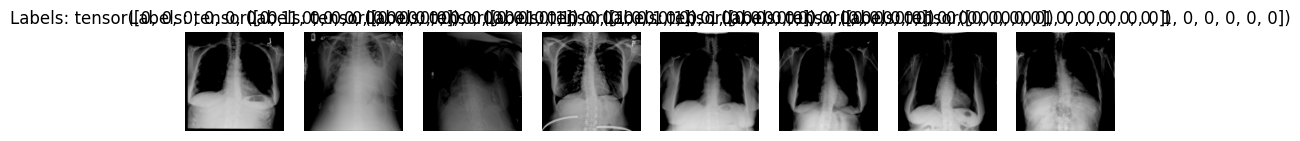

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

# Define a custom dataset class for multi-label classification
class CXRDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Extract unique labels and create a mapping
        all_labels = set(label for labels in self.df['Finding Labels'].str.split('|') for label in labels)
        self.label_map = {label: i for i, label in enumerate(all_labels)}

        # Convert multi-label strings to lists of labels
        self.df['Finding Labels'] = self.df['Finding Labels'].apply(lambda x: x.split('|'))

        # Initialize MultiLabelBinarizer and fit on the entire dataset
        self.label_binarizer = MultiLabelBinarizer(classes=list(self.label_map.keys()))
        self.label_binarizer.fit(self.df['Finding Labels'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.df.iloc[idx, 1]

        # Use the MultiLabelBinarizer to convert labels to binary format
        labels_bin = self.label_binarizer.transform([labels])[0]

        if self.transform:
            image = self.transform(image)

        return image, labels_bin

# Display basic information about the dataset
print(df.info())
print(df['Finding Labels'].apply(lambda x: x.split('|')).explode().value_counts())

# Create dataset and dataloaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CXRDataset(csv_file=csv_path, root_dir="/content/images/", transform=transform)

# Visualize a few images
batch_size =8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Show images
def show_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i in range(min(8, len(images))):
        plt.subplot(1, 8, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f"Labels: {labels[i]}")
        plt.axis('off')
    plt.show()

# Show images
show_images(images, labels)

In [29]:
from sklearn.model_selection import train_test_split

# Step 3: Create dataset and dataloaders (Repeating for clarity)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CXRDataset(csv_file=csv_path, root_dir="/content/images/", transform=transform)

# Step 4: Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2,random_state=47)

print(train_df['Finding Labels'].value_counts())
print("\n\n")
print("ABOVE IS TRAIN, BELOW IS VAL\n\n\n")
print(val_df['Finding Labels'].value_counts())

# Create datasets and dataloaders for training and validation
train_dataset = CXRDataset(csv_file="/content/reallysmallsample.csv", root_dir="/content/images/", transform=transform)
val_dataset = CXRDataset(csv_file="/content/reallysmallsample.csv", root_dir="/content/images/", transform=transform)

# Define batch size
batch_size =32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

No Finding                                          281
Effusion                                             56
Infiltration                                         42
Atelectasis                                          24
Cardiomegaly                                         22
                                                   ... 
Atelectasis|Emphysema                                 1
Cardiomegaly|Mass|Pleural_Thickening                  1
Effusion|Fibrosis|Mass|Nodule|Pleural_Thickening      1
Edema                                                 1
Mass|Pleural_Thickening                               1
Name: Finding Labels, Length: 88, dtype: int64



ABOVE IS TRAIN, BELOW IS VAL



No Finding                                                69
Infiltration                                              21
Atelectasis                                                9
Effusion                                                   8
Effusion|Infiltration                                     

In [55]:
import torch.optim as optim

#Define a Convolutional Neural Network (CNN)
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # Use a pre-trained ResNet18 model as the base
        self.base_model = models.resnet18(pretrained=True)

        # Modify the last fully connected layer to match the number of classes
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Step 6: Train the model

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes
num_classes = len(dataset.label_map)

# Instantiate the model
model = CustomCNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of training epochs
num_epochs = 5

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define a function to calculate accuracy
def calculate_accuracy(outputs, labels):
    predictions = torch.sigmoid(outputs) > 0.5  # Use a threshold of 0.5 for binary classification
    correct = predictions == labels.byte()
    accuracy = torch.mean(correct.float())
    return accuracy.item()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Calculate training accuracy
        correct_train_predictions += calculate_accuracy(outputs, labels) * len(labels)
        total_train_samples += len(labels)

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # Calculate overall training accuracy for the epoch
    train_accuracy = correct_train_predictions / total_train_samples
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels.float())
            total_val_loss += val_loss.item()

            # Calculate validation accuracy
            correct_val_predictions += calculate_accuracy(val_outputs, val_labels) * len(val_labels)
            total_val_samples += len(val_labels)

    average_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)

    # Calculate overall validation accuracy for the epoch
    val_accuracy = correct_val_predictions / total_val_samples
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Validation Loss: {average_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")


torch.save(model.state_dict(), "/content/models/mymodel.pth")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.3038, Train Accuracy: 0.8780
Epoch 1/5, Validation Loss: 0.2648, Validation Accuracy: 0.9118
Epoch 2/5, Train Loss: 0.2117, Train Accuracy: 0.9197
Epoch 2/5, Validation Loss: 0.1931, Validation Accuracy: 0.9289
Epoch 3/5, Train Loss: 0.1843, Train Accuracy: 0.9291
Epoch 3/5, Validation Loss: 0.2076, Validation Accuracy: 0.9156
Epoch 4/5, Train Loss: 0.1661, Train Accuracy: 0.9356
Epoch 4/5, Validation Loss: 0.1832, Validation Accuracy: 0.9281
Epoch 5/5, Train Loss: 0.1388, Train Accuracy: 0.9463
Epoch 5/5, Validation Loss: 0.2496, Validation Accuracy: 0.8918


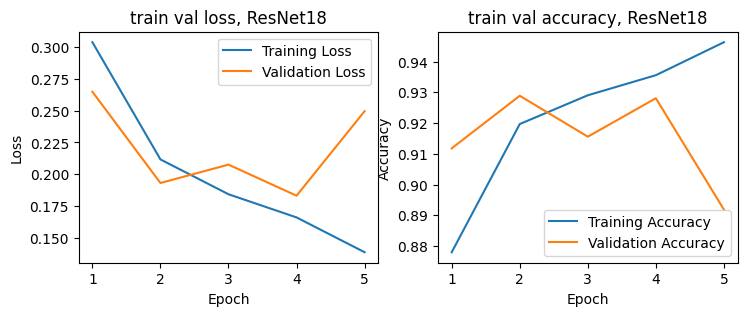

In [56]:
# Plotting the learning curves

plt.figure(figsize=(8.5,3))
# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('train val loss, ResNet18')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('train val accuracy, ResNet18')
plt.legend()

plt.show()

<ipython-input-69-f31de82ee750>:42: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)


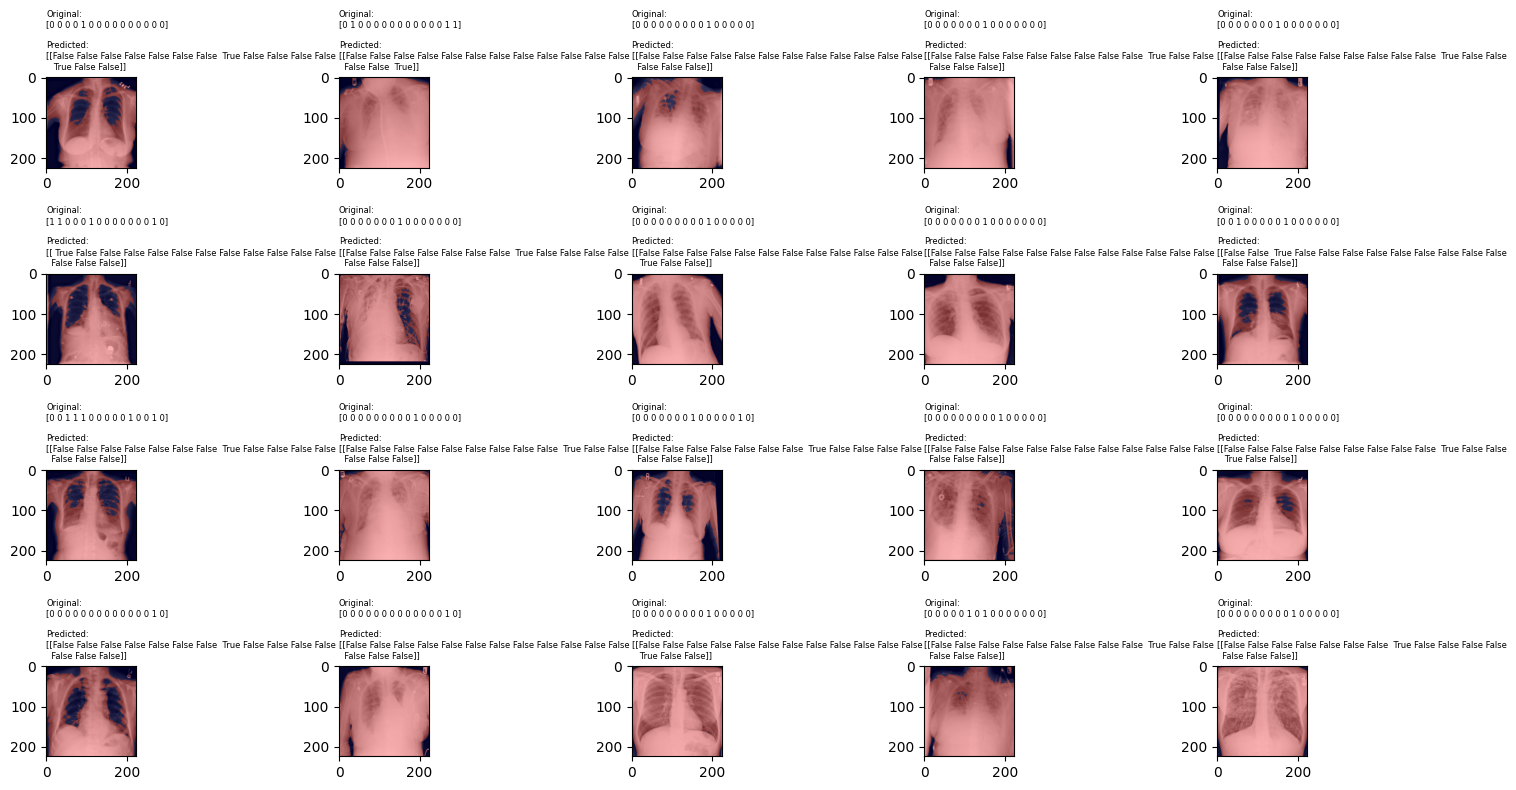

In [69]:
import cv2
import numpy as np
from torchvision.transforms import ToPILImage


# ... (Previous code for dataset, model, optimizer, criterion)

# Load the trained model
model.load_state_dict(torch.load("/content/models/mymodel.pth"))
model.eval()

# Choose some images for visualization (you can adjust this based on your dataset)
num_images_to_visualize = 20
visualize_indices = np.random.choice(len(val_dataset), size=num_images_to_visualize, replace=False)

# Function to generate CAM
def generate_cam(image, model, target_class):
    model.eval()

    # Get the last convolutional layer
    last_conv_layer = model.base_model.layer4[-1]

    # Create a new model without the final fully connected layer
    model_without_fc = nn.Sequential(
        *list(model.base_model.children())[:-1]
    ).to(device)

    # Forward pass to get the feature maps
    with torch.no_grad():
        output = model_without_fc(image)

    # Get the weights of the fully connected layer
    fc_params = list(model.base_model.fc.parameters())
    weight_softmax = np.squeeze(fc_params[0].cpu().data.numpy())

    # Get the feature map size
    feature_map_size = output.shape[2:]

    # Resize the CAM to match the original image size
    cam = cv2.resize(weight_softmax.reshape((1, -1)), (feature_map_size[1], feature_map_size[0]))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # Convert the CAM to 3D
    cam_heatmap = np.uint8(255 * cam)
    cam_heatmap = cv2.applyColorMap(cam_heatmap, cv2.COLORMAP_JET)

    # Combine the CAM with the original image
    cam_result = np.float32(cam_heatmap) + np.float32(image.cpu().numpy().squeeze().transpose((1, 2, 0)))
    cam_result = cam_result / np.max(cam_result)

    return cam_result


# Visualize CAM for selected images
plt.figure(figsize=(15, 8))
to_pil = ToPILImage()

for i, idx in enumerate(visualize_indices, 1):
    image, labels_bin = val_dataset[idx]
    image = image.unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        output = model(image)
    predicted_class = torch.sigmoid(output) > 0.5

    # Generate CAM for the predicted class
    cam_result = generate_cam(image, model, predicted_class)

    # Overlay the CAM on the original image
    overlaid_image = image.cpu().squeeze().numpy().transpose((1, 2, 0))
    overlaid_image = (overlaid_image - overlaid_image.min()) / (overlaid_image.max() - overlaid_image.min())
    overlaid_image = cv2.resize(overlaid_image, (224, 224))  # Resize to match the original image size
    overlaid_image = (overlaid_image * 255).astype(np.uint8)

    cam_heatmap = cv2.applyColorMap((cam_result * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlaid_image = cv2.addWeighted(overlaid_image, 0.7, cam_heatmap, 0.3, 0)

    # Plot the overlaid image with improved spacing
    plt.subplot(4, 5, i)
    plt.imshow(overlaid_image)
    plt.title(f'Original:\n{labels_bin}\n\nPredicted:\n{predicted_class.cpu().numpy()}', loc='left', fontsize=6)

plt.tight_layout()
plt.show()